In [2]:
# import packages
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly
import os

In [47]:
# change viewing options
pd.set_option('display.max_columns', None)  
pd.set_option('max_colwidth', -1)

### Step 1: Import data

In [3]:
os.listdir()

['data_exploration.ipynb',
 'training_set_labels.csv',
 'submission_format.csv',
 'README.md',
 'training_set_features.csv',
 '.ipynb_checkpoints',
 '.git',
 'test_set_features.csv']

In [4]:
# read in the data
train = pd.read_csv("training_set_features.csv")
train_labels = pd.read_csv("training_set_labels.csv")

### Step 2: Analyze data

Before analyzing the data, I did some background research on the H1N1 and seasonal flu viruses, as well as the associated vaccination responses to each. Based off information from both news outlets and scientific literature, I proposed a few questions to test during data exploration:

#### Question 0: How many people get the H1N1 vaccine? Flu vaccine?

(This question doesn't come from outside sources, but it would be interesting to know the proportion of H1N1 vaccine and flu vaccine adoption, as a whole, prior to further analysis)

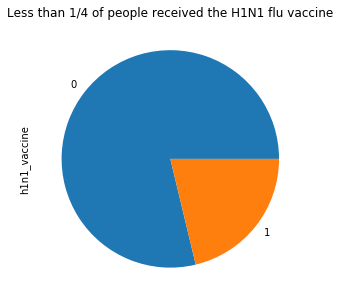

In [121]:
# for the h1n1 vaccine
train_labels['h1n1_vaccine'].value_counts().plot.pie(y="mass", figsize = (5,5))
plt.title("Less than 1/4 of people received the H1N1 flu vaccine")
plt.show()

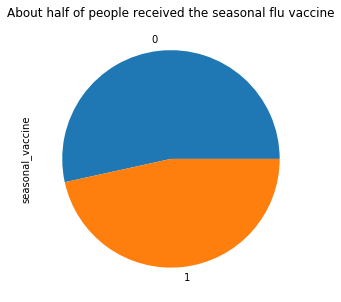

In [120]:
# for the flu vaccine
train_labels['seasonal_vaccine'].value_counts().plot.pie(y="mass", figsize = (5,5))
plt.title("About half of people received the seasonal flu vaccine")
plt.show()

We already see a class imbalance in the adoption of the H1N1 vaccine (less than 1/4 of people chose to receive the H1N1 vaccine), which could be important to keep in mind during future analysis. 

As a follow-up, is there a correlation between adoption of the H1N1 vaccine and the seasonal flu vaccine?

In [122]:
train_labels['h1n1_vaccine'].corr(train_labels['seasonal_vaccine'], method = 'pearson')

0.37714265306144495

We see a mild correlation (r=0.377), which makes sense. If you get one vaccine, you likely will get the other vaccine. How did a person getting or not getting one vaccine influence whether they got the other vaccine? Let's look at this using a table:

In [124]:
tab = pd.crosstab(train_labels['h1n1_vaccine'], train_labels['seasonal_vaccine'])
tab

seasonal_vaccine,0,1
h1n1_vaccine,,
0,13295,7738
1,977,4697


Let's get a better idea of what this table is telling us:

In [129]:
print(f"The percent of people who got both vaccines: {round(tab.iloc[1, 1] * 100/ sum(tab.sum()), 3)}%")
print(f"The percent of people who got neither vaccine: {round(tab.iloc[0, 0] * 100/ sum(tab.sum()), 3)}%")
print(f"The percent of people who got the H1N1 vaccine but not the seasonal flu vaccine: {round(tab.iloc[1, 0] * 100/ sum(tab.sum()), 3)}%")
print(f"The percent of people who got the seasonal flu vaccine but not the H1N1 vaccine: {round(tab.iloc[0, 1] * 100/ sum(tab.sum()), 3)}%")

The percent of people who got both vaccines: 17.587%
The percent of people who got neither vaccine: 49.781%
The percent of people who got the H1N1 vaccine but not the seasonal flu vaccine: 3.658%
The percent of people who got the seasonal flu vaccine but not the H1N1 vaccine: 28.974%


We see that half of respondents got neither vaccine, while only 18% of respondents got both vaccines. A significant proportion, ~29% of respondents, got the seasonal flu vaccine but not the H1N1 vaccine. It might be worth subsetting the dataset by (1) people who got both vaccines, (2) people who got neither vaccine, and (3) people who got the seasonal flu vaccine but not the H1N1 vaccine, and see if we notice any trends.

#### Question 1:  Are people with children more likely to get flu shots? 

Let's analyze this for the H1N1 vaccine first:

In [78]:
# raw counts
pd.crosstab(train['household_children'],  train_labels['h1n1_vaccine'])

h1n1_vaccine,0,1
household_children,,
0.0,14689,3983
1.0,2501,674
2.0,2235,629
3.0,1398,349


In [81]:
# normalized version
tab = pd.crosstab(train['household_children'],  train_labels['h1n1_vaccine'], margins = True, normalize = True)
tab

h1n1_vaccine,0,1,All
household_children,,,
0.0,0.555182,0.150540,0.705722
1.0,0.094527,0.025474,0.120002
2.0,0.084474,0.023774,0.108247
3.0,0.052838,0.013191,0.066029
All,0.787021,0.212979,1.000000


In [82]:
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

In [52]:
# get tabulation of each
tab = pd.crosstab(train['h1n1_concern'], train_labels['h1n1_vaccine'])
tab_normalized = pd.crosstab(train['h1n1_concern'], train_labels['h1n1_vaccine'], margins = True, normalize = True)

In [57]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

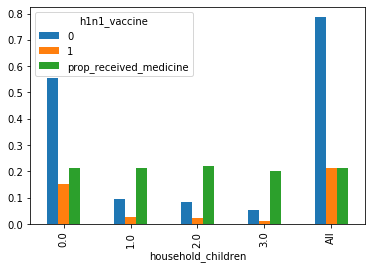

In [84]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

Comment: It seems like the relative proportion of people who received medicine is consistent across the # of children in a household

Now, let's analyze this in the case of the flu virus

In [86]:
# raw counts
pd.crosstab(train['household_children'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
household_children,,
0.0,9217,9455
1.0,1953,1222
2.0,1769,1095
3.0,1148,599


In [87]:
# normalized version
tab = pd.crosstab(train['household_children'],  train_labels['seasonal_vaccine'], margins = True, normalize = True)
tab

seasonal_vaccine,0,1,All
household_children,,,
0.0,0.348363,0.357359,0.705722
1.0,0.073815,0.046186,0.120002
2.0,0.066861,0.041386,0.108247
3.0,0.043390,0.022640,0.066029
All,0.532429,0.467571,1.000000


In [88]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

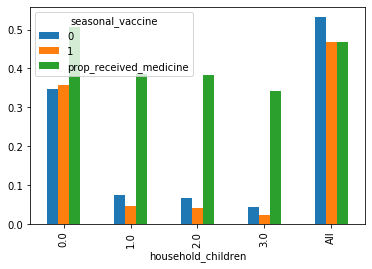

In [89]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

Comment: It seems like people were much more likely to get the seasonal flu vaccine when they didn't have children in the household

General comment: It seems weird that the # of children in the household doesn't affect one's likelihood of getting a H1N1 vaccine, but that those with no children in the household are more likely to get a seasonal vaccine. This seems to go against past news and research (which suggests that people are more likely to get the vaccine if there's people at home who are at risk, such as children and the elderly). I wonder if the findings here are moderated by some other variable. 

#### Question 2: How do vaccination rates vary by age?

Past literature suggests that the elderly are more likely to get vaccinations than any other age groups, and that as one gets older, they become more likely to get vaccination. 

This effect is also likely moderated by the presence of pre-existing conditions (and perhaps other explanatory variables), so it would be good to account for this as well.

Let's first analyze this for the H1N1 vaccine first:

In [102]:
# raw counts
pd.crosstab(train['age_group'],  train_labels['h1n1_vaccine'])

h1n1_vaccine,0,1
age_group,,
18 - 34 Years,4224,991
35 - 44 Years,3087,761
45 - 54 Years,4218,1020
55 - 64 Years,4212,1351
65+ Years,5292,1551


In [103]:
# normalized version
tab = pd.crosstab(train['age_group'],  train_labels['h1n1_vaccine'], margins = True, normalize = True)
tab

h1n1_vaccine,0,1,All
age_group,,,
18 - 34 Years,0.158161,0.037106,0.195267
35 - 44 Years,0.115588,0.028494,0.144082
45 - 54 Years,0.157936,0.038192,0.196128
55 - 64 Years,0.157711,0.050586,0.208297
65+ Years,0.198150,0.058075,0.256225
All,0.787546,0.212454,1.000000


In [104]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

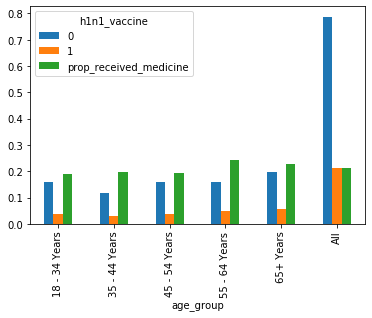

In [105]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

For the H1N1 vaccine, it doesn't seem like age affects how likely a person will get the vaccine.

Now let's analyze this in the case of the flu virus

In [106]:
# raw counts
pd.crosstab(train['age_group'],  train_labels['seasonal_vaccine'])

seasonal_vaccine,0,1
age_group,,
18 - 34 Years,3731,1484
35 - 44 Years,2453,1395
45 - 54 Years,3136,2102
55 - 64 Years,2719,2844
65+ Years,2233,4610


In [107]:
# normalized version
tab = pd.crosstab(train['age_group'],  train_labels['seasonal_vaccine'], margins = True, normalize = True)
tab

seasonal_vaccine,0,1,All
age_group,,,
18 - 34 Years,0.139701,0.055566,0.195267
35 - 44 Years,0.091849,0.052233,0.144082
45 - 54 Years,0.117422,0.078706,0.196128
55 - 64 Years,0.101809,0.106489,0.208297
65+ Years,0.083611,0.172614,0.256225
All,0.534392,0.465608,1.000000


In [108]:
# get proportion of people receiving h1n1 vaccine, by row
tab['prop_received_medicine'] = tab[1] / (tab[0]  + tab[1]) 

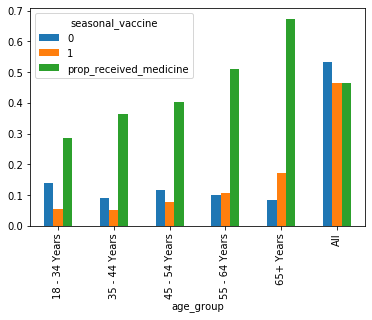

In [109]:
tab[[0, 1, 'prop_received_medicine']].plot(kind = 'bar')
plt.show()

For the seasonal flu vaccine, it seems like the likelihood of getting the vaccine increases as one gets older

#### Question 3: Can we look at stacked bar charts to see how vaccination rates vary by a set of variables that past literature tells us are indicative of vaccination rates?

Rather than looking at bar charts, can we look at stacked bar charts and see how the proportions of vaccination rates vary by each variable?

Note: the following EDA is inspired by this post: https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/

In [133]:
# step 1: join the labels and training set
df_joined = train.join(train_labels, on=['respondent_id'], how='inner', rsuffix="_")

In [135]:
df_joined.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id_,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [158]:
# step 2: create a function that creates the vaccination rate plot, by column:
def vaccination_rate_plot(col, target, ax=None):
    """
    Stacked bar plot, plotting the vaccination rates by the column of interest
    
    Args:
        • col: column of interest
        • target: label of interest (h1n1_vaccine or seasonal_vaccine)
        • ax: matplotlib axes object to attach plot to
    """
    
    # get counts table
    counts = pd.crosstab(df_joined[col], df_joined[target])
    
    # get counts, by group in the column
    group_counts = counts.sum(axis='columns')
    
    # get proportions of no vaccination, vaccination, by group
    props = counts.div(group_counts, axis='index')
    
    # plot proportions
    props.plot(kind="barh", stacked=True, ax=ax)
    
    # invert y axis, remove labels
    ax.invert_yaxis()
    ax.legend().remove()

From past news coverage and literature, what factors seem to affect people's tendency to get the flu vaccine? (in no particular order)
1. Age
2. Gender
3. Education
4. Degree of concern about the virus
5. Degree of awareness about the virus
6. Whether their doctor recommended the vaccine
7. If they have a chronic medical condition
8. If they're in contact with very young children (since the children can be at risk)
9. Their opinion about the vaccine (does it work? Is there a risk? Can they get sick from it?)
10. If they're a healthcare worker (or in the healthcare field). 

****Sources are cited in the bottom of this document.****

So, let's add these columns in a list, loop through each of them, and get a plot of the proportion of vaccination rates

In [159]:
# get columns that could be of interest
cols_to_iterate = ['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
                  'chronic_med_condition', 'child_under_6_months', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 
                  'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 
                  'sex', 'income_poverty']

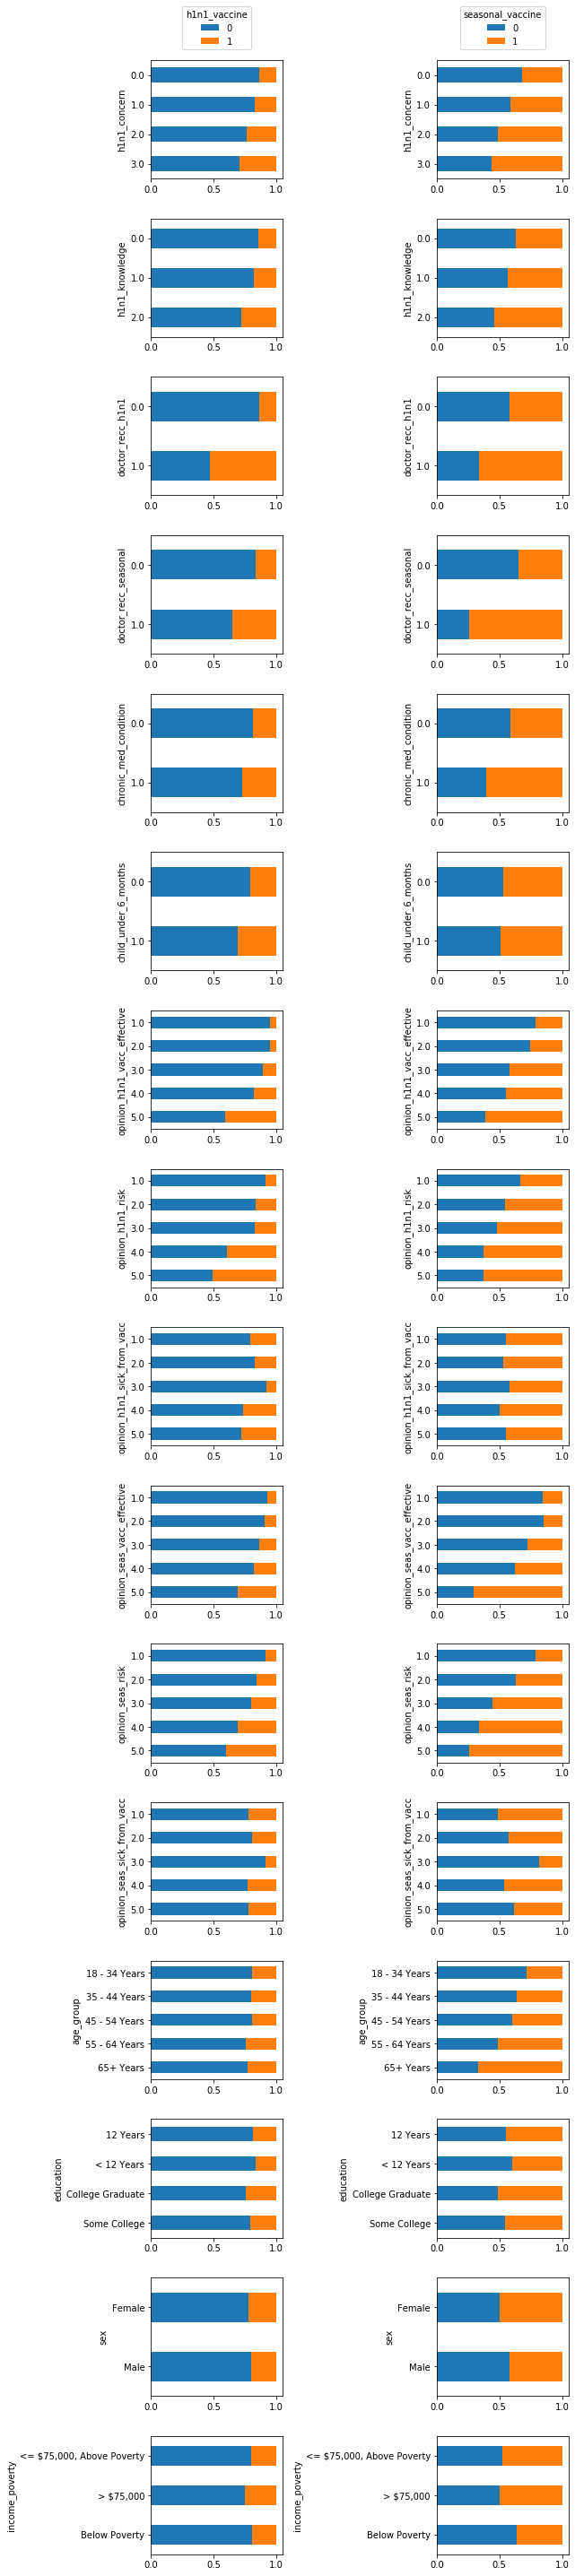

In [160]:
# set up figure, axes
fig, ax = plt.subplots(len(cols_to_iterate), 2, 
                       figsize=(9,len(cols_to_iterate)*2.5))

# iterate through all columns
for index, col in enumerate(cols_to_iterate):
    
    # make first plot, the h1n1 plot
    vaccination_rate_plot(col, 'h1n1_vaccine', ax=ax[index, 0])
    # make second plot, the seasonal flu plot
    vaccination_rate_plot(col, 'seasonal_vaccine', ax=ax[index, 1])
    
# set up labels
ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

# get tight layout
fig.tight_layout()

### Sources

Below are the sources that I used in my research for this project (not including help with StackOverflow or the pandas/numpy/matplotlib documentation)